### Direct Marketing in Banking - Propensity Modelling with Tabular Data

# Part 1: SageMaker Autopilot, XGBoost, and HPO

> *This notebook works well with the `Python 3 (Data Science 3.0)` kernel on SageMaker Studio*

This workshop explores a tabular, [binary classification](https://en.wikipedia.org/wiki/Binary_classification) use-case with significant **class imbalance**: predicting which of a bank's customers are likely to respond to a targeted marketing campaign.

In this first notebook, you'll first tackle the challenge with AutoML using [Amazon SageMaker Autopilot](), and then dive deeper with [SageMaker built-in XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) and [automatic hyperparameter tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html).

## Contents

> ℹ️ **Tip:** You can use the Table of Contents panel in the left sidebar on JupyterLab / SageMaker Studio, to view and navigate sections

1. **[Prepare our environment](#Prepare-our-environment)**
1. **[Fetch the example dataset](#Fetch-the-example-dataset)**
1. **[Starting fast with SageMaker Autopilot](#Starting-fast-with-SageMaker-Autopilot)**
1. **[Diving deeper with XGBoost](#Diving-deeper-with-XGBoost)**
1. **[Hyperparameter Optimization (HPO)](#Hyperparameter-Optimization-(HPO))**
1. **[Conclusions](#Conclusions)**

## Prepare our environment

To get started, we'll need to:

- **Import** some useful libraries (as in any Python notebook)
- **Configure** -
    - The [Amazon S3 bucket](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html#CoreConcepts) and folder where **data** should be stored (to keep our environment tidy)
    - The [IAM role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html) defining what **permissions** the jobs you create will have
- **Connect** to AWS in general (with [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)) and SageMaker in particular (with the [sagemaker SDK](https://sagemaker.readthedocs.io/en/stable/)), to use the cloud services

Run the cell below, to set these up.

> ℹ️ **Tip:** Just like in a regular [JupyterLab notebook](https://jupyterlab.readthedocs.io/en/stable/user/interface.html), you can run code cells by clicking in to target cell - and then pressing the play (▶️) button in the toolbar or `Shift+Enter` on the keyboard.

In [2]:
%load_ext autoreload
%autoreload 2

# Python Built-Ins:
import json
import time

# External Dependencies:
import boto3  # General-purpose AWS SDK for Python
import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # Tabular data utilities
import sagemaker  # High-level SDK specifically for Amazon SageMaker
from sagemaker.automl.automl import AutoML as AutoMLEstimator
from sagemaker.feature_store.feature_group import FeatureGroup

# Local Helper Functions:
import util

# Setting up SageMaker parameters
sgmk_session = sagemaker.Session()  # Connect to SageMaker APIs
region = sgmk_session.boto_session.region_name  # The AWS Region we're using (e.g. 'ap-southeast-1')
bucket_name = sgmk_session.default_bucket()  # Select an Amazon S3 bucket
bucket_prefix = "sm101/direct-marketing"  # Location in the bucket to store our files
sgmk_role = sagemaker.get_execution_role()  # IAM Execution Role to use for permissions

print(f"s3://{bucket_name}/{bucket_prefix}")
print(sgmk_role)

s3://sagemaker-us-east-1-680025043312/sm101/direct-marketing
arn:aws:iam::680025043312:role/cfn-SageMakerExecutionRole-1IHVLRREB04RA


## Fetch the example dataset

This example uses the [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) as per: S. Moro, P. Cortez and P. Rita. *A Data-Driven Approach to Predict the Success of Bank Telemarketing.* Decision Support Systems, Elsevier, 62:22-31, June 2014.

In the following cells we'll download the dataset locally, store it in Amazon S3, and **also** load a transformed copy into [Amazon SageMaker Feature Store](https://aws.amazon.com/sagemaker/feature-store/).

> ℹ️ **Tip:** You can train and deploy models in SageMaker **without using** SageMaker Feature Store, but we introduce it in this example to show you to a wider range of SageMaker features.
>
> Don't worry too much about the details of how the data loading is done here - but for the curious, you can check out the code behind these helper functions in  [util/data.py](util/data.py).

In [3]:
raw_data_path = util.data.fetch_sample_data()
print(f"Got: {raw_data_path}\n")

print("Uploading raw dataset to Amazon S3:")
raw_data_s3uri = f"s3://{bucket_name}/{bucket_prefix}/raw.csv"
!aws s3 cp {raw_data_path} {raw_data_s3uri}

https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Extracting to data...
Got: data/bank-additional/bank-additional-full.csv

Uploading raw dataset to Amazon S3:
upload: data/bank-additional/bank-additional-full.csv to s3://sagemaker-us-east-1-680025043312/sm101/direct-marketing/raw.csv


In [4]:
%%time
feature_group_name = "sm101-direct-marketing"
print("Loading data to SageMaker Feature Store:")

# No need to re-run this if you've done it already - just set `feature_group_name` variable.
util.data.load_sample_data(
    raw_data_path,
    fg_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/feature-store",
    feature_group_name=feature_group_name,
    ignore_cols=[
        "duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"
    ],
)

Loading data to SageMaker Feature Store:
Loading data/bank-additional/bank-additional-full.csv...
Transforming dataframe...
Setting up SageMaker Feature Store feature group: sm101-direct-marketing
Waiting for creation of Feature Group sm101-direct-marketing (Initial status Creating)....
Feature Group sm101-direct-marketing successfully created.
Configuring feature metadata...
Ingesting data to SageMaker Feature Store...
Waiting for propagation to offline Feature Store...
Done!
CPU times: user 1.7 s, sys: 311 ms, total: 2.01 s
Wall time: 6min 26s


'sm101-direct-marketing'

> ⏰ **You don't have to wait** for this cell to finish running: As soon as you reach the `Ingesting data...` step, you're ready to continue on to the next section!

▶️ As soon as you reach the `Ingesting data...` stage, you'll be able to see your "feature group" in the SageMaker Feature Store catalog:

- Select the 🏠 *SageMaker Home* icon from the left sidebar in SageMaker Studio
- Choose `Data > Feature Store` from the sidebar menu to open the Feature Store UI

Note you can explore the catalog either by "feature group" (table), or searching for individual features themselves. Descriptions and some tags have already been populated for you, based on the dataset description from UCI.

![](img/feature-store-features.png "Screenshot of SMStudio Feature Store UI showing feature catalog")

## Starting fast with SageMaker Autopilot

> ℹ️ **Tip: To skip the following manual steps** - Scroll down and you'll find code to create a similar setup through the API.

Autopilot makes it easy to get started on tabular ML problems, even without extensive data preparation or writing any code. This is because:

- Autopilot will automatically explore multiple data pre-processing options, algorithms, and hyperparameters for you - to identify a high-performing model
- Even if you **do** want to perform some manual feature engineering first, Autopilot has direct integrations from [SageMaker Data Wrangler](https://aws.amazon.com/sagemaker/data-wrangler/) (SageMaker's low-code/no-code data preparation tool). You could explore this by creating a new Data Wrangler Flow from the launcher or File > New > Data Wrangler Flow.

▶️ While your data finishes importing to SageMaker Feature Store, let's **start an Autopilot experiment using the raw CSV file**

1. **Select** the 🏠 *SageMaker Home* icon from the left sidebar in SageMaker Studio
1. **Choose** `AutoML` from the sidebar menu
1. **Click** the `Create Autopilot Experiment` button

▶️ In the first **Experiment and data details** step:

- Choose an **Experiment name** - something like `sm101-autopilot-1` should be fine.
- For **S3 location**, you can use the `Browse` button or just enter the URI from `raw_data_s3uri` earlier in this notebook.
- Leave any other settings as default and click **Next**

![](img/autopilot-01-select-data.png "Screenshot of Autopilot workflow selecting the raw data CSV in S3")

▶️ In the next **Experiment and data details** step:

- For the **Target** column, select `y`
- **De-select** the features from `ignore_cols` earlier in this notebook, to **exclude** them from the model.
    - ⚠️ As discussed on the [UCI dataset page](https://archive.ics.uci.edu/ml/datasets/bank+marketing), the `duration` field is particularly inappropriate to include in modelling as it leaks information about the target variable (calls with longer duration were more likely to be successful sales, and call duration cannot be known at the point of targeting which customers to approach. We also exclude the final 5 macro-economic variables as these may not be easily available at inference time.

![](img/autopilot-02-select-features.png "Screenshot of Autopilot workflow excluding ignored features and selecting y as target variable")

▶️ In the next **Training method** step:

- You can leave the default **Auto** selection method. Since this dataset is small, the Ensembling method will be automatically selected. If you like, you could create a second Experiment to compare both methods.

![](img/autopilot-03-select-mode.png "Select Auto mode in the UI, which will be equivalent to Ensembling for this small dataset")

▶️ In the next **Deployment and advanced settings** step:

- **IF you selected "HPO" training method in the previous screen**: Consider reducing the `Runtime > Max candidates` setting from 250 to ~50. The default setting would likely take several hours to train.
- **Otherwise**, leave all settings as default

▶️ **Click next**, review your settings, and then **Create experiment**.

![](img/autopilot-04-runtime.png "Screenshot selecting smaller number of max candidates in runtime menu - only applicable for HPO jobs")

Alternatively, you may like to create Autopilot jobs through the [CreateAutoMLJob API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateAutoMLJob.html) or - as shown below - the high-level `AutoML` class in the [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/api/training/automl.html):

> ⚠️ You don't need to run the following cell if you already created an Autopilot job manually!

In [ ]:
# There's no need to run this cell if you created an Autopilot job manually!
autopilot = AutoMLEstimator(
    role=sgmk_role,
    target_attribute_name="y",

    # At the time of writing, the high-level Python SDK didn't support ensembling mode - so we'll
    # use the HPO mode instead with limited max_candidates:
    max_candidates=20,

    # Optional params to keep the environment tidy:
    base_job_name="sm101-autopilot",
    output_path=f"s3://{bucket_name}/{bucket_prefix}/autopilot",
)

autopilot.fit(raw_data_s3uri, wait=False)

## Diving deeper with XGBoost

Another useful tool to build high-performing models quickly is the set of [built-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) offered by SageMaker for a wide range of use-cases.

Instead of using Autopilot to automate the process of data pre-processing and hyperparameter tuning, we can directly use these built-in algorithms (or custom ones) for finer-grained control. In this example, we'll show the [XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html).


### Understand the algorithm requirements

The first step to using any SageMaker built-in algorithm is understanding its overall characteristics and the interface it offers. Here we'll refer to:

- The [algorithm docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) to understand the **detail** of the **data formats** and **(hyper)-parameters** it supports - as well as sample notebooks
- The [Common Parameters doc](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) to compare the **high-level configurations** and capabilities between algorithms.


As discussed on the algorithm doc page, there are 2 ways to use XGBoost in SageMaker: As a pre-built algorithm (no script required), or as a framework (with your own custom training script).

In this example, we'll use pre-built algorithm mode so only need to fetch the container image URI:

In [5]:
image_uri = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.5-1")
print(image_uri)

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1


### Extract batch data from the SageMaker Feature Store

Next, we'll extract a snapshot of data from the (offline/batch) SageMaker Feature Store via serverless SQL query with [Amazon Athena](https://aws.amazon.com/athena/), to prepare for model training.

Feature Store **tracks the history** of records, allowing you to reproduce point-in-time snapshots even when features change over time.

- **Example queries** for time-travel and other views are available through the SageMaker Studio Feature Store UI: From your Feature Group, switch to the "Sample queries" tab.
- The additional `event_time`, `write_time`, `api_invocation_time`, `is_deleted` and `row_number` fields returned in the below query are metadata for this history tracking - so won't be used in the actual model training.

In [6]:
feature_group = FeatureGroup(feature_group_name, sagemaker_session=sgmk_session)
query = feature_group.athena_query()
table_name = query.table_name

data_extract_s3uri = f"s3://{bucket_name}/{bucket_prefix}/data-extract"
!aws s3 rm --quiet --recursive {data_extract_s3uri}  # Clear any previous extractions
print(f"Querying feature store to extract snapshot at:\n{data_extract_s3uri}")
query.run(
    f"""
    SELECT *
    FROM
        (SELECT *,
        row_number()
        OVER
            (PARTITION BY "customer_id"
            ORDER BY "event_time" DESC, Api_Invocation_Time DESC, write_time DESC)
        AS row_number
        FROM "sagemaker_featurestore"."{table_name}"
        WHERE "event_time" <= {time.time()})
    WHERE row_number = 1 AND NOT is_deleted;
    """,
    output_location=data_extract_s3uri,
)
query.wait()

full_df = query.as_dataframe()
print(f"Got {len(full_df)} records")
full_df

Querying feature store to extract snapshot at:
s3://sagemaker-us-east-1-680025043312/sm101/direct-marketing/data-extract
Got 41188 records


,y,age,job,marital,education,default,housing,loan,contact,month,...,previous,poutcome,no_previous_contact,not_working,customer_id,event_time,write_time,api_invocation_time,is_deleted,row_number
0,0,60,unknown,single,unknown,unknown,no,no,telephone,may,...,0,nonexistent,1,0,C-00007736,1.648518e+09,2023-03-29 01:52:47.749,2023-03-29 01:46:52.000,False,1
1,0,39,unemployed,married,university.degree,no,yes,no,telephone,jun,...,0,nonexistent,1,1,C-00007773,1.648518e+09,2023-03-29 01:52:47.749,2023-03-29 01:46:52.000,False,1
2,0,38,entrepreneur,divorced,basic.9y,no,yes,yes,cellular,nov,...,0,nonexistent,1,0,C-00025798,1.648518e+09,2023-03-29 01:52:47.749,2023-03-29 01:46:54.000,False,1
3,0,37,admin.,married,high.school,unknown,yes,no,telephone,may,...,0,nonexistent,1,0,C-00000196,1.648518e+09,2023-03-29 01:52:47.749,2023-03-29 01:46:55.000,False,1
4,0,45,blue-collar,married,basic.9y,unknown,yes,no,cellular,apr,...,1,failure,1,0,C-00028457,1.648518e+09,2023-03-29 01:52:47.749,2023-03-29 01:46:57.000,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,21,admin.,single,high.school,no,no,no,cellular,apr,...,0,nonexistent,1,0,C-00030304,1.648518e+09,2023-03-29 01:52:47.801,2023-03-29 01:47:41.000,False,1
41184,0,38,technician,married,professional.course,no,yes,no,cellular,mar,...,0,nonexistent,1,0,C-00027762,1.648518e+09,2023-03-29 01:52:47.801,2023-03-29 01:47:42.000,False,1
41185,0,36,technician,married,professional.course,unknown,yes,no,cellular,aug,...,0,nonexistent,1,0,C-00022657,1.648518e+09,2023-03-29 01:52:47.801,2023-03-29 01:47:42.000,False,1
41186,1,44,retired,single,high.school,no,no,no,cellular,aug,...,0,nonexistent,1,1,C-00040513,1.648518e+09,2023-03-29 01:52:47.801,2023-03-29 01:47:42.000,False,1


### Split and prepare datasets

From the [Input and Output Interface section](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost) of the algorithm doc, we know that XGBoost expects CSV or LibSVM data inputs for training, and optionally validation.

Some extra data preparation is also required because (at the time of writing), this XGBoost algorithm version doesn't fully support string categorical features.

Below we **one-hot encode the categorical fields**, and then split the pre-processed data into randomly shuffled training, validation, and test sets.

In [7]:
df_model_data = full_df.drop(
    columns=[
        "customer_id", "event_time", "write_time", "api_invocation_time", "is_deleted", "row_number"
    ],
    errors="ignore",  # Your DF may not have 'row_number' if you didn't do a time travel query
)
df_model_data

# Need to one-hot encode?
df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators

# Shuffle and splitting dataset
train_data, validation_data, test_data = np.split(
    df_model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
)

# Create CSV files for Train / Validation / Test
train_data.to_csv("data/train.csv", index=False, header=False)
validation_data.to_csv("data/validation.csv", index=False, header=False)
test_data.to_csv("data/test.csv", index=False, header=False)

df_model_data

,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,60,4,999,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,39,4,999,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,38,1,999,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
3,0,37,1,999,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,45,4,999,1,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,21,2,999,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
41184,0,38,5,999,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
41185,0,36,2,999,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
41186,1,44,4,999,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


The datasets specific for this algorithm can then be uploaded to Amazon S3, ready to use as inputs to the training job:

In [8]:
model_data_s3uri = f"s3://{bucket_name}/{bucket_prefix}/model-data-xgb"

train_data_s3uri = model_data_s3uri + "/train/data.csv"
train_data.to_csv(train_data_s3uri, index=False, header=False)
validation_data_s3uri = model_data_s3uri + "/validation/data.csv"
validation_data.to_csv(validation_data_s3uri, index=False, header=False)
test_data_s3uri = model_data_s3uri + "/test/data.csv"
test_data.to_csv(test_data_s3uri, index=False, header=False)

### Train a model

With the data prepared in a compatible format, and the parameters collected, we're ready to run a training job through the SageMaker SDK [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) class, which provides a high-level wrapper over the underlying [SageMaker CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrainingJob.html).

The training job runs on **separate, containerized infrastructure** from this notebook:

- **You specify** the number and type of instances, and the IAM permissions with which the job runs (which could be separate from the notebook execution role)
- The job is **independent** from the notebook: The input parameters, logs, metrics, and output artifacts are still available through the APIs even if the notebook disconnects/restarts part way through. (See [Estimator.attach(...)](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.attach) classmethod for re-attaching to previous/ongoing jobs).
- A range of **other infrastructure parameters** are available like:
    - [SageMaker managed spot](https://docs.aws.amazon.com/sagemaker/latest/dg/model-managed-spot-training.html), to optimize infrastructure costs
    - [Warm pool keep-alive](https://docs.aws.amazon.com/sagemaker/latest/dg/train-warm-pools.html), to speed up start of sequential jobs

In [9]:
%%time

xgb_estimator = sagemaker.estimator.Estimator(
    base_job_name="xgboost",
    role=sgmk_role,  # IAM role for job permissions (to access the S3 data)
    image_uri=image_uri,  # XGBoost algorithm container
    instance_count=1,
    instance_type="ml.m5.xlarge",  # Type of compute instance
    max_run=25 * 60,  # Limit job to 25 minutes

    # OPTIONALLY use spot instances to reduce cost:
    use_spot_instances=True,
    max_wait=30 * 60,  # Maximum clock time (including spot delays)

    output_path=f"s3://{bucket_name}/{bucket_prefix}/train-output",
)

xgb_estimator.set_hyperparameters(
    num_round=50,  # int: [1,300]
    max_depth=5,  # int: [1,10]
    alpha=2.5,  # float: [0,5]
    eta=0.5,  # float: [0,1]
    objective="binary:logistic",
    eval_metric="auc",
)

# Launch a SageMaker Training job by passing the S3 path of the datasets:
xgb_estimator.fit({
    "train": sagemaker.inputs.TrainingInput(train_data_s3uri, content_type="csv"),
    "validation": sagemaker.inputs.TrainingInput(validation_data_s3uri, content_type="csv"),
})

INFO:sagemaker:Creating training-job with name: xgboost-2023-03-29-01-53-39-089


2023-03-29 01:53:40 Starting - Starting the training job...
2023-03-29 01:53:55 Starting - Preparing the instances for training......
2023-03-29 01:54:53 Downloading - Downloading input data...
2023-03-29 01:55:44 Training - Training image download completed. Training in progress...[2023-03-29 01:55:52.485 ip-10-2-126-39.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-29 01:55:52.553 ip-10-2-126-39.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-03-29:01:55:52:INFO] Imported framework sagemaker_xgboost_container.training
[2023-03-29:01:55:52:INFO] Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
[2023-03-29:01:55:52:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2023-03-29:01:55:52:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-29:01:55:52:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-03-29:01:55:5

As well as the logs streamed to the notebook, you can follow the status of the job in:
- The [Training > Training jobs page of the AWS Console for SageMaker](https://console.aws.amazon.com/sagemaker/home?#/jobs)
    - Including links to Amazon CloudWatch console to drill in to job logs and metric graphs
- The Resources > Experiments and trials pane in SageMaker Studio
    - Jobs started without an explicit Experiment configuration will appear under the "Unassigned trial components" folder

### Batch inference

Once the model is trained, we can either deploy it to a real-time endpoint to make inference requests on-demand, or use it to run batch jobs on existing datasets.

In this first example, we'll use [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to run batch inference. SageMaker will spin up a temporary cluster, send our data through the model, and shut down the resources as soon as all the input data is processed.

To get started, you can create a [Transformer object](https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html) directly from `estimator.transformer(...)`. However, in this we'll go via `create_model()` first so we can easily add the model to SageMaker Model Registry later:

In [10]:
xgb_model = xgb_estimator.create_model()

Because SageMaker Batch Transform orchestrates the process of sending data through the model and consolidating the outputs, there are a range of extra parameters beyond the basic S3 output location and instance size/type.

By default, SageMaker Batch Transform treats each file in the input S3 prefix as one request payload and generates an output file of the same name, appending `.out`. Below we configure more specific handling for tabular data though:

- Interpret each line of input files as a separate record with `split_type`, and interpret each line of output data as separate record with `assemble_with`.
- Make `MultiRecord` batch requests up to `max_payload` Megabytes each - allowing up to `max_concurrent_transforms` concurrent requests per instance.
- Exclude the `y` target label column (which is present in the test data) from model requests with `input_filter`.
- Include the input data as well as the predictions in the result with `join_source`.

The result will still be a single `.csv.out` file for each `.csv` input, but SageMaker has control of individual request batch sizes to optimize resource use.

In [11]:
eval_s3uri = f"s3://{bucket_name}/{bucket_prefix}/xgb-evaluation"

xgb_transformer = xgb_model.transformer(
    output_path=eval_s3uri,  # S3 output location
    instance_count=1,  # Number of instances to spin up for the job
    instance_type="ml.m5.large",  # Instance type to use for inference
    strategy="MultiRecord",  # Request inference in batches, for efficiency
    accept="text/csv",  # Request CSV response format
    assemble_with="Line",  # Consolidate response records with newlines between
    max_concurrent_transforms=2,  # Instances sent up to N requests concurrently
    max_payload=1,  # Max size per request (in Megabytes)
)

xgb_transformer.base_transform_job_name="sm101-dm-xgboost"
xgb_transformer.transform(
    test_data_s3uri,
    content_type="text/csv",  # Test data is in CSV format
    split_type="Line",  # Each line of test data is a separate record
    join_source="Input",  # Output joined data including the input features as well as prediction
    input_filter="$[1:]",  # Exclude the leading (actual target value) field
    # wait=True,  # (Default True) Block the notebook kernel until the job completes
    # logs=True,  # (Default True) Stream job logs to the notebook
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-03-29-01-57-26-661
INFO:sagemaker:Creating transform job with name: sm101-dm-xgboost-2023-03-29-01-57-27-329


.............................[2023-03-29:02:02:16:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-29:02:02:16:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-29:02:02:16:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-03-29 02:02:16 +0000] [15] [INFO] Starting gunico

Once the job completes, we can read the dataframe direct from Amazon S3:

In [12]:
df_eval = pd.read_csv(
    eval_s3uri + "/data.csv.out",
    header=None,
    names=test_data.columns.tolist() + ["y_prob"],
)
df_eval

,y,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_prob
0,1,30,1,999,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0.115193
1,1,56,7,999,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0.014007
2,0,32,2,999,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0.107840
3,0,58,2,999,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0.017722
4,0,33,3,999,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0.099736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,0,41,2,999,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0.025666
4115,0,30,1,999,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0.113512
4116,0,48,2,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0.040490
4117,0,38,1,999,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0.280069


This algorithm only outputs positive-class probability scores for binary classification - not including assigned class labels.

For assessing performance we can either assume a particular `decision_threshold` (for example, scores over than 0.5 are assigned to class 1) - or take whatever threshold maximises the F1 score of the model.

The utility function below generates a graphical report here in the notebook, but also saves a JSON file in [SageMaker Model Quality Metrics compatible-format](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-metrics.html): Similar to if we'd run a [SageMaker Model Quality Monitoring job](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality.html).

Using inferred F1-maximizing threshold for metrics
upload: data/report-xgboost.json to s3://sagemaker-us-east-1-680025043312/sm101/direct-marketing/sagemaker-xgboost-2023-03-29-01-57-26-661/model-quality.json


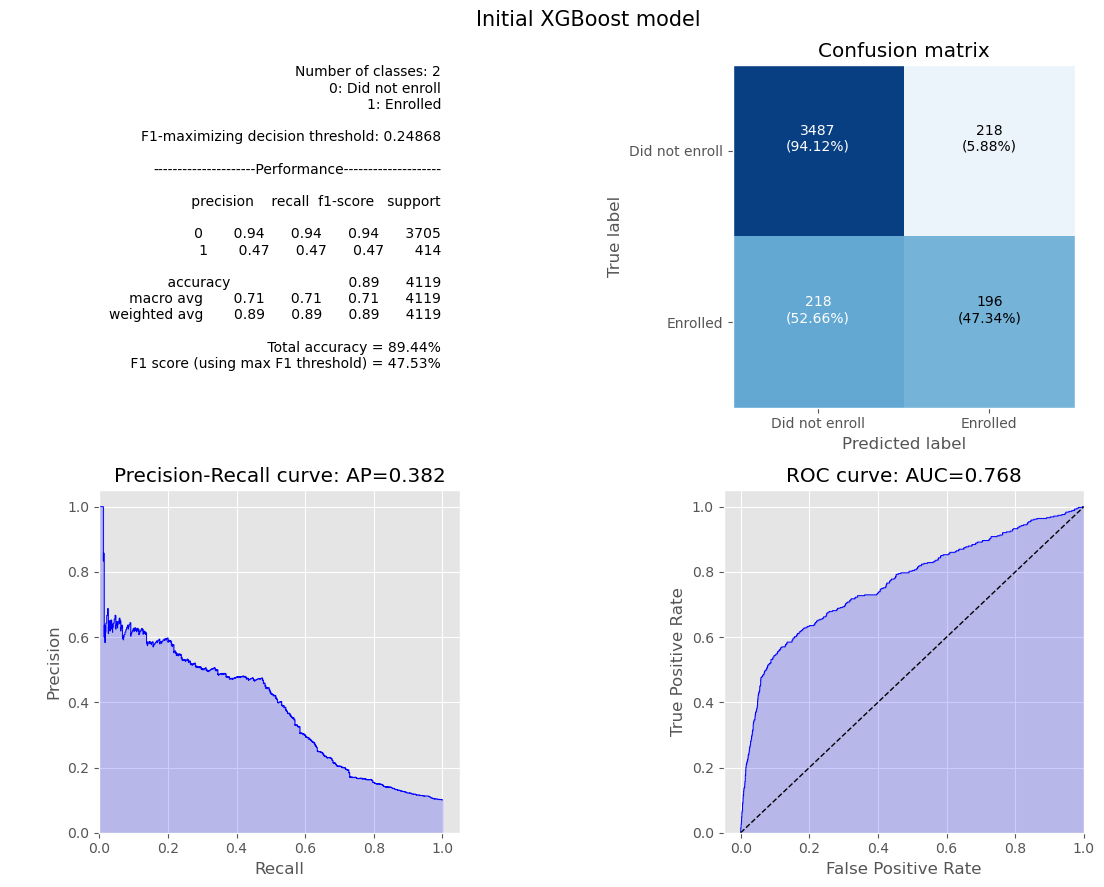

In [13]:
report = util.reporting.generate_binary_classification_report(
    y_real=df_eval["y"].values,
    y_predict_proba=df_eval["y_prob"].values,
    # y_predict_label not available for XGBoost output format
    # Optionally set decision_threshold=0.5 to apply a specific threshold, instead of maximizing F1:
    # decision_threshold=0.5,
    class_names_list=["Did not enroll", "Enrolled"],
    title="Initial XGBoost model",
)

# Store the model quality report locally and on Amazon S3:
with open("data/report-xgboost.json", "w") as f:
    json.dump(report, f, indent=2)
model_quality_s3uri = f"s3://{bucket_name}/{bucket_prefix}/{xgb_model.name}/model-quality.json"
!aws s3 cp data/report-xgboost.json {model_quality_s3uri}

### Register and share the model

The trained model is already available in the SageMaker APIs to deploy and re-use (you should see it, for example, in the [Models page of the SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/models)).

However, we can improve discoverability and governance by cataloging it in the [SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html). Here extra metadata can be associated, including I/O formats and the model quality report generated above:

In [14]:
xgb_model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    model_package_group_name="sm101-dm",
    description="Initial XGBoost model",
    model_metrics=sagemaker.model_metrics.ModelMetrics(
        model_statistics=sagemaker.model_metrics.MetricsSource(
            content_type="application/json",
            s3_uri=model_quality_s3uri,
        ),
    ),
    domain="MACHINE_LEARNING",
    task="CLASSIFICATION",
    sample_payload_url=test_data_s3uri,
)

You can explore and manage your versioned registry model packages in SageMaker Studio: Including **reviewing and approving** new versions to trigger automated deployments.

## Hyperparameter Optimization (HPO)

> ⏰ *Note, with the default settings below, the hyperparameter tuning job can take up to ~20 minutes to complete.*

While AutoML frameworks like AutoGluon try to encapsulate model ensembling, single-algorithm approaches like XGBoost can often benefit from **hyperparameter tuning** to find the best values for settings like `alpha`, `eta` and `max_depth` on a particular problem.

Exploring these parameter combinations by hand can be time-consuming - especially if considering more than a couple of parameters.

[SageMaker automatic model tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) can run intelligent exploration and optimization jobs for you automatically, so you can focus on building and applying insights - rather than managing these experiments.

As shown below, you can set up a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) wrapper around your standard `Estimator`. The key requirements are:

1. Your job outputs at least one **metric** which the tuner can maximize or minimize (this is handled automatically for most built-in algorithms)
1. Specify **ranges for the hyperparameters** you'd like to explore
1. Specify the **strategy and resource limits** for the job

SageMaker HPO supports a range of [strategies](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) including exploratory tools like Grid and Random search, and efficient HPO-oriented optimization tools like Bayesian Optimization and Hyperband.

In this example, we'll use Bayesian search to optimize Area Under the ROC Curve (AUC) of our XGBoost model [See Machine Learning Key Concepts](https://docs.aws.amazon.com/machine-learning/latest/dg/amazon-machine-learning-key-concepts.html) for more info if you're unfamiliar with these metrics.

In [17]:
%%time

# import required HPO objects
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

# Target metric is already built in to the algorithm, so we just specify the name:
objective = "validation:auc"

# Configure hyperparameter ranges to explore:
ranges = {
    "num_round": IntegerParameter(1, 300),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
}

# Configure the tuner:
xgb_tuner = HyperparameterTuner(
    estimator=xgb_estimator,  # The SageMaker estimator object
    hyperparameter_ranges=ranges,
    max_jobs=15,  # Max total number of training jobs
    max_parallel_jobs=3,  # How many training jobs can run in parallel
    strategy="Bayesian",  # the internal optimization strategy of HPO
    objective_metric_name=objective,
    objective_type="Maximize",  # For AUC, higher = better
)

# Start the job:
xgb_tuner.fit(
    {
        "train": sagemaker.inputs.TrainingInput(train_data_s3uri, content_type="csv"),
        "validation": sagemaker.inputs.TrainingInput(validation_data_s3uri, content_type="csv"),
    },
    wait=True,  # Optionally block the notebook until the job is complete.
)

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-230329-0214


.......................................................................................................................................................................!
CPU times: user 731 ms, sys: 66.6 ms, total: 797 ms
Wall time: 14min 21s


Note that `max_parallel_jobs` creates a **trade-off** between job run time and result quality: The more jobs are run in parallel, the faster the `max_jobs` will be completed, but the less information the strategy has about completed jobs when selecting parameter combinations to try next.

As with training and transform jobs, hyperparameter tuning runs separately from the notebook so won't be interrupted if you lose connection or shut down. You can track job progress in the [Training > Hyperparameter tuning jobs page](https://console.aws.amazon.com/sagemaker/home?#/hyper-tuning-jobs) of the SageMaker console and the [DescribeHyperParameterTuningJob API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeHyperParameterTuningJob.html).

You can always set `wait=False` or interrupt the cell (Square stop ⏹ button in the toolbar) to continue working in the notebook while HPO runs in the background. You can later resume waiting for the active job by calling `tuner.wait()` as shown below. Just like the Estimator, you won't be able to `deploy()` the tuner's model until the tuning job is complete.

In [16]:
xgb_tuner.wait()

............

KeyboardInterrupt: 

The individual training jobs created by the model tuning are listed in SageMaker just like manually-created ones, and the HPO job builds up a leaderboard of models based on the objective metric.

In this example we'll simply deploy the "best" model, but you can also explore the jobs for deeper insights: See [this sample notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) for examples.


### Deploy and test the optimized model

As with single training jobs, you can use the results of your hyperparameter tuning runs for either batch or online inference.

You can directly call the [HyperparameterTuner.deploy(...)](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html#sagemaker.tuner.HyperparameterTuner.deploy) method to deploy the winning model to an endpoint - but as before, we'll create a `Model` object first to link back to SageMaker Model Registry later.

In [18]:
best_job_name = xgb_tuner.best_training_job()
print("Best training job from HPO run:", best_job_name)

hpo_model = sagemaker.estimator.Estimator.attach(best_job_name).create_model()

Best training job from HPO run: sagemaker-xgboost-230329-0214-003-e2d86acc

2023-03-29 02:17:01 Starting - Preparing the instances for training
2023-03-29 02:17:01 Downloading - Downloading input data
2023-03-29 02:17:01 Training - Training image download completed. Training in progress.
2023-03-29 02:17:01 Uploading - Uploading generated training model
2023-03-29 02:17:01 Completed - Training job completed


In [19]:
hpo_predictor = hpo_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.CSVDeserializer(),
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-03-29-02-30-38-207
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-03-29-02-30-38-828
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-03-29-02-30-38-828


-----!

### Use the endpoint

The [Predictor](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html) class in the SageMaker SDK provides a high-level Python wrapper for creating and invoking inference endpoints which is useful in notebooks... Although consumer applications can also use the low-level [SageMaker Runtime API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_Operations_Amazon_SageMaker_Runtime.html) (with [Boto3 in Python](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker-runtime.html), or other AWS SDKs in other languages) to avoid this extra library dependency.

SageMaker is a general-purpose ML platform supporting a wide range of use-cases beyond tabular data, so we need to explicitly configure what type of content we're sending in endpoint requests (here CSV) and specifying for the response (here JSON) - via the SDK [serializer](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html) and [deserializer classes](https://sagemaker.readthedocs.io/en/stable/api/inference/deserializers.html). You can also define your own classes to fully customize the Python I/O interface of the `predictor.predict()` method and the on-the-wire data format transmitted to the HTTPS endpoint. 

Again, when using a pre-built algorithm, refer to the [algorithm docs](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost) to see what input and output formats are supported at inference time.

We'll send `text/csv` inputs and request `text/csv` outputs from the model, similarly to the batch transform case earlier:

In [ ]:
# getting the predicted probabilities of the best model
hpo_probabilities = np.array(
    hpo_predictor.predict(test_data.drop(["y"], axis=1).values),
    dtype=float,
).squeeze()

hpo_probabilities

> ⚠️ **Note:** The above single `predict()` call makes a single `InvokeEndpoint` request with the **entire test dataset in one batch**. That's fine for a small dataset like this one, but practical use-cases will need to balance between throughput efficiency (large batches reduce communication overhead), endpoint memory requirements, and payload size limits (6MB for real-time endpoints, at the time of writing).

Our model has calculated probability scores (in the interval [0,1]) of a potential customer enrolling for a term deposit. We can join these predictions back on to the original dataframe here in the notebook, to explore performance similar to the batch results earlier:

In [ ]:
hpo_report = util.reporting.generate_binary_classification_report(
    y_real=test_data["y"].values,
    y_predict_proba=hpo_probabilities,
    # y_predict_label not available for XGBoost output format
    # Optionally set decision_threshold=0.5 to apply a specific threshold, instead of maximizing F1:
    # decision_threshold=0.5,
    class_names_list=["Did not enroll", "Enrolled"],
    title="HP-tuned XGBoost model",
)

# Store the model quality report locally and on Amazon S3:
with open("data/report-xgbhpo.json", "w") as f:
    json.dump(hpo_report, f, indent=2)
hpo_quality_s3uri = f"s3://{bucket_name}/{bucket_prefix}/{hpo_model.name}/model-quality.json"
!aws s3 cp data/report-xgbhpo.json {hpo_quality_s3uri}

...And finally, we can register this tuned model as a second candidate version in our SageMaker Model Registry group:

In [ ]:
hpo_model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    model_package_group_name="sm101-dm",
    description="HP-tuned XGBoost model",
    model_metrics=sagemaker.model_metrics.ModelMetrics(
        model_statistics=sagemaker.model_metrics.MetricsSource(
            content_type="application/json",
            s3_uri=hpo_quality_s3uri,
        ),
    ),
    domain="MACHINE_LEARNING",
    task="CLASSIFICATION",
    sample_payload_url=test_data_s3uri,
)

▶️ **Open** your model group in SageMaker Model Registry

- You can `Shift+Click` or `Control+Click` to **select multiple versions** in the model group
- With multiple versions selected, you can `Right Click` to `Compare model versions` for a side-by-side comparison of different models' charts and statistics.

## Conclusions

In this notebook, we saw how [**SageMaker Autopilot**](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-automate-model-development.html) can accelerate new tabular ML projects to a high-accuracy, deployable model with no coding required. We also saw how you can dive deeper using the [SageMaker built-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) and [automatic hyperparameter tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), to customize your models without implementing common algorithms from scratch.

We also saw brief intros to how [SageMaker Feature Store](https://docs.aws.amazon.com/sagemaker/latest/dg/feature-store.html) can help catalog shared feature data, and how [SageMaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html) helps with tracking and managing trained models. For more information on these MLOps features, you can refer to the documentation and the official [SageMaker notebook examples repository](https://github.com/aws/amazon-sagemaker-examples).

We used a relatively small number of trials in this HPO run to keep the run-time fast, so you might not have seen much improvement: But HPO is particularly useful when the space of parameters becomes large and you can allocate sufficient compute resources for the algorithm to explore best combinations for you.

Although [SageMaker Autopilot](https://docs.aws.amazon.com/sagemaker/latest/dg/autopilot-automate-model-development.html) is perhaps the quickest way to deliver strong initial results on a new tabular data project, SageMaker built-in algorithms support a wide range of use-cases from text and vision to more niche tabular problem types. Combining built-in algorithms with SageMaker HPO can really boost their accuracy.

In fact, you'll see that Autopilot uses many of these same tools under the hood: Creating HPO jobs when running in HPO mode, using SageMaker Processing for data pre-processing experiments, and making use of the XGBoost and AutoGluon-Tabular algorithms.

▶️ In the optional [Notebook 2 AutoGluon](2%20AutoGluon%20(Optional).ipynb), you'll see another SageMaker built-in algorithm in action and learn how automatic ensembling can help deliver even more accurate models.

## Releasing cloud resources

While training job clusters are shut down automatically when the job stops, inference endpoints stay provisioned until explicitly deleted.

To avoid unnecessary charges, un-comment and run the following code to clean up your AutoGluon model endpoint when finished experimenting. You can also check the [Inference > Endpoints page of the SageMaker console](https://console.aws.amazon.com/sagemaker/home?#/endpoints) for any other running endpoints.

In [ ]:
# hpo_predictor.delete_endpoint(delete_endpoint_config=True)